# Stack Overflow Questions Quality Rating Prediction

![](https://miro.medium.com/max/1200/1*ROagAxRi9uL-jeFLy5wQEQ.png)



### Contents
1. Abstract
2. Dataset
3. Goal
4. Importing all the required libraries and Dataset
5. Data Cleaning
6. Data Visualization or, EDA
7. Prediction Models
    - Logistic Regression
    - Random forest Classifier
    - Decision Tree Classifier
    - KNN Classifier
    - Naive Bayes Classifier
    - XgBoosting Classifier
8. Model Comparison
9. Conclusion
***********************

### Abstract
Community Question Answering websites (CQA) have a growing popularity as a way of providing and searching of information. CQA attract users as they provide a direct and rapid way to find the desired information. As recognizing good questions can improve the CQA services and the user’s experience, the current study focuses on question quality instead. Specifically, we predict question quality and investigate the features which influence it. The influence of the question tags, length of the question title and body, presence of a code snippet, the user reputation and terms used to formulate the question are tested. For each set of dependent variables, Ridge regression models are estimated. The results indicate that the inclusion of terms in the models improves their predictive power. Additionally, we investigate which lexical terms determine high and low quality questions. The terms with the highest and lowest coefficients are semantically analyzed. The analysis shows that terms predicting high quality are terms expressing, among others, excitement, negative experience or terms regarding exceptions. Terms predicting low quality questions are terms containing spelling errors or indicating off-topic questions and interjections.

### Dataset
The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate.

### Goal
The gaol of this project is to make a prediction model which will predict the quality of the questions from the Stack Overflow website depending on the various factors.
*****************

### Importing the required libraries and Dataset

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve

warnings.simplefilter("ignore")

Read the data and don't use the low quality edit data

### Data Preprocessing and Some EDA

In [22]:
data = pd.read_csv("../input/60k-stack-overflow-questions-with-quality-rate/data.csv")
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ


All the open questions are grouped under a single class (1), while the closed one is grouped under (0)

In [23]:
data = data.drop(['Id', 'Tags', 'CreationDate'], axis=1)
data['Y'] = data['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT': 1, 'HQ':2})
data.head()

,Title,Body,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,0
1,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,1
2,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,2
3,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,2
4,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",2


Let's join the title and the body of the text data so that we can use both of them in our classification

In [25]:
data['text'] = data['Title'] + ' ' + data['Body']
data = data.drop(['Title', 'Body'], axis=1)
data.head()

,Y,text
0,0,Java: Repeat Task Every Random Seconds <p>I'm ...
1,1,How to get all the child records from differen...
2,2,Why are Java Optionals immutable? <p>I'd like ...
3,2,Text Overlay Image with Darkened Opacity React...
4,2,Why ternary operator in swift is so picky? <p>...


### Data Cleaning

In [26]:
# Clean the data
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^(a-zA-Z)\s]','', text)
    return text
data['text'] = data['text'].apply(clean_text)

### Splitting the Data
Let's now split the dataset into training and validation sets.

**Training and Testing Dataset Spliting using the `train_test_split`**
  
  * Immporting the library from the sklearn.model_selection
  * Split the dataset into 80:20 ratio
  * x_train and y_train are the trainning datasets
  * x_test and y_test are the testing datasets
  * After the spliting of the datasets the model is ready to be prepared!

In [27]:
# Define how much percent data you wanna split
split_pcent = 0.20
split = int(split_pcent * len(data))

# Shuffles dataframe
data = data.sample(frac=1).reset_index(drop=True)

# Training Sets
train = data[split:]
trainX = train['text']
trainY = train['Y'].values

# Validation Sets
valid = data[:split]
validX = valid['text']
validY = valid['Y'].values

assert trainX.shape == trainY.shape
assert validX.shape == validY.shape

print(f"Training Data Shape: {validX.shape}\nValidation Data Shape: {validX.shape}")

Training Data Shape: (12000,)
Validation Data Shape: (12000,)


### Vectorizing the Data
Let's vectorize the data so it's in the numerical format

In [28]:
# Load the vectorizer, fit on training set, transform on validation set
vectorizer = TfidfVectorizer()
trainX = vectorizer.fit_transform(trainX)
validX = vectorizer.transform(validX)

*****************
##   Prediction Model Creation
A classification model tries to draw some conclusion from the input values given for training. It will predict the class labels/categories for the new data.

Here we are going to prepare several Classification machine learning models based on those we will do a comparative analysis that which model is better among them.

We are using six different classification algorithms -
* **K-Nearest Neighbours Algorithm** : K-Nearest Neighbour is one of the simplest Machine Learning algorithms based on Supervised Learning technique. K-NN algorithm assumes the similarity between the new case/data and available cases and put the new case into the category that is most similar to the available categories. K-NN algorithm stores all the available data and classifies a new data point based on the similarity. This means when new data appears then it can be easily classified into a well suite category by using K- NN algorithm.


* **Random Forest Classifier** : Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.


* **Logistic Regression** : Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).


* **Naive Bayes Classifcation Algorithm** :  Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.


* **Decision Tree Classifier** : Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.


* **XgBoost Classifier** : XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) A wide range of applications: Can be used to solve regression, classification, ranking, and user-defined prediction problems.

Let's quickly get into the algorithms!
*******************

### 1. Logistic Regression
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

Let's first start with our good old, Logistic Regression!

In [29]:
# Define and fit the classifier on the data
lr_classifier = LogisticRegression(C=1.)
lr_classifier.fit(trainX, trainY)

LogisticRegression()

In [30]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Logsitic Regression Classifier is: {(lr_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Logsitic Regression Classifier is: 87.79%


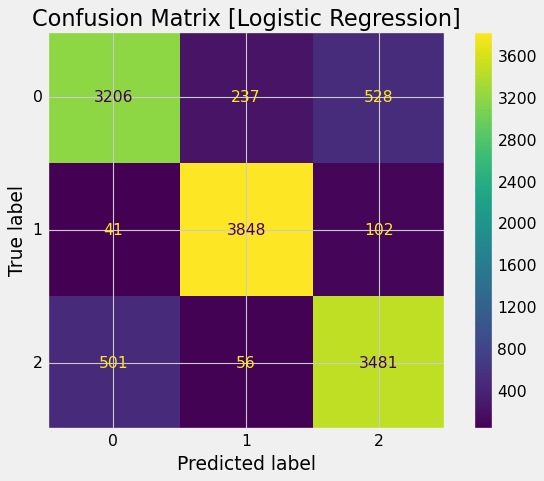

In [31]:
# Also plot the metric
plot_metric(lr_classifier, validX, validY, "Logistic Regression")

*****************
### 2. Multinomial Naive Bayes
Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Let's now switch to the naive the bayes, the NAIVE BAYES!

In [32]:
# Define and fit the classifier on the data
nb_classifier = MultinomialNB()
nb_classifier.fit(trainX, trainY)

MultinomialNB()

In [33]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 77.94%


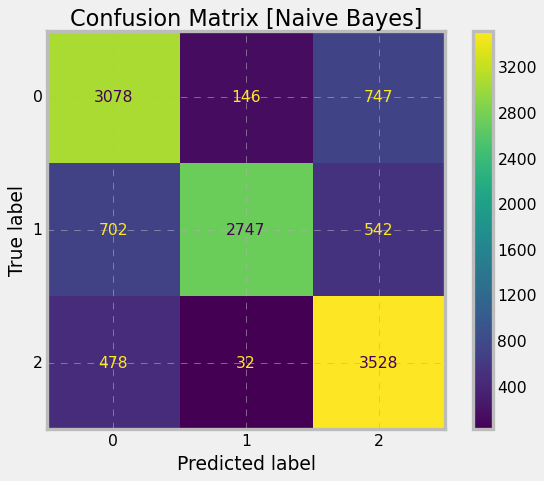

In [34]:
# Also plot the metric
plot_metric(nb_classifier, validX, validY, "Naive Bayes")

*******************
### 3. Random Forest Classifier
Random Forest is a popular machine learning algorithm that belongs to the supervised learning technique. It can be used for both Classification and Regression problems in ML. It is based on the concept of ensemble learning, which is a process of combining multiple classifiers to solve a complex problem and to improve the performance of the model.

Let's now enter the forest with the Random Forest Classifier and see where it takes us!

In [35]:
# Define and fit the classifier on the data
rf_classifier = RandomForestClassifier()
rf_classifier.fit(trainX, trainY)

RandomForestClassifier()

In [36]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 82.96%


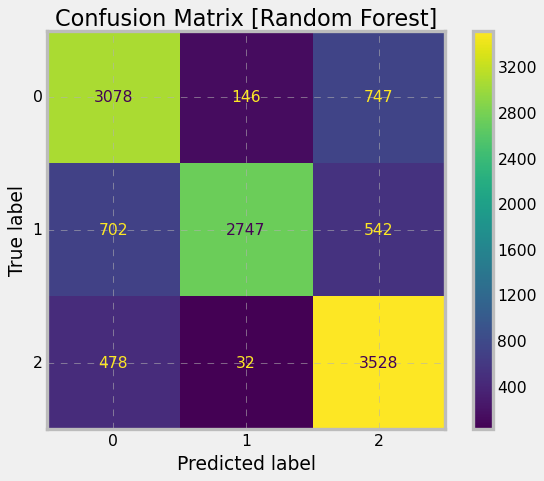

In [37]:
# Also plot the metric
plot_metric(nb_classifier, validX, validY, "Random Forest")

*************************************
### 4. Decision Tree Classifier
Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

Let's now take some decisions using the Decision Tree Classifer

In [44]:
# Define and fit the classifier on the data
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(trainX, trainY)

DecisionTreeClassifier()

In [45]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of Decision Tree Clf. is: 79.72%


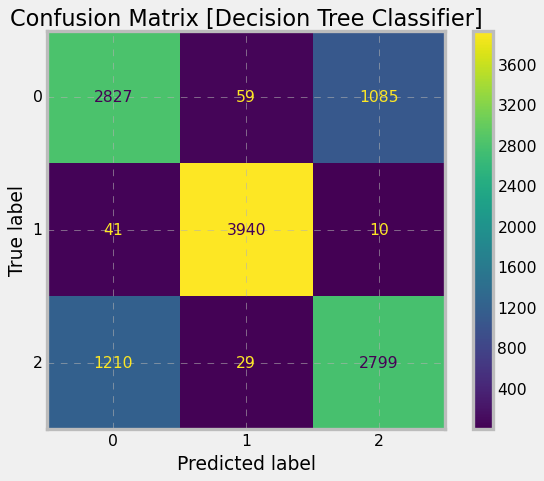

In [46]:
# Also plot the metric
plot_metric(dt_classifier, validX, validY, "Decision Tree Classifier")

**************************
### 5. KNN Classifier
K-Nearest Neighbour is one of the simplest Machine Learning algorithms based on Supervised Learning technique. K-NN algorithm assumes the similarity between the new case/data and available cases and put the new case into the category that is most similar to the available categories. K-NN algorithm stores all the available data and classifies a new data point based on the similarity. This means when new data appears then it can be easily classified into a well suite category by using K- NN algorithm.

We now are going to use KNN Classifier for this task.

In [47]:
# Define and fit the classifier on the data
kn_classifier = KNeighborsClassifier()
kn_classifier.fit(trainX, trainY)

KNeighborsClassifier()

In [48]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of KNN Clf. is: {(kn_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of KNN Clf. is: 56.51%


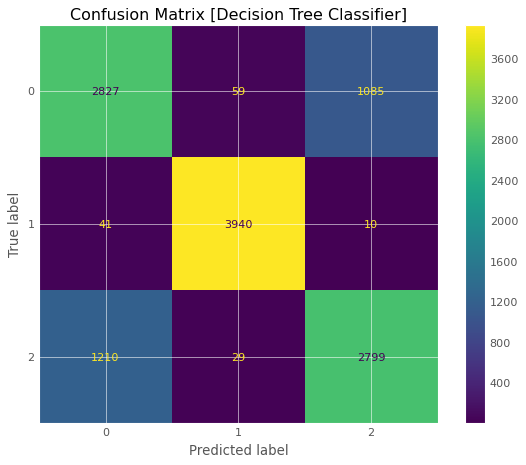

In [49]:
# Also plot the metric
plot_metric(dt_classifier, validX, validY, "Decision Tree Classifier")

*******************************
### 6. XGBoost Classifier
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) A wide range of applications: Can be used to solve regression, classification, ranking, and user-defined prediction problems.

Finally, let's use the XGBoost Classifier and then we'll compare all the different classifiers so far

In [50]:
# Define and fit the classifier on the data
xg_classifier = XGBClassifier()
xg_classifier.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
# Print the accuracy score of the classifier
print(f"Validation Accuracy of XGBoost Clf. is: {(xg_classifier.score(validX, validY))*100:.2f}%")

Validation Accuracy of XGBoost Clf. is: 87.76%


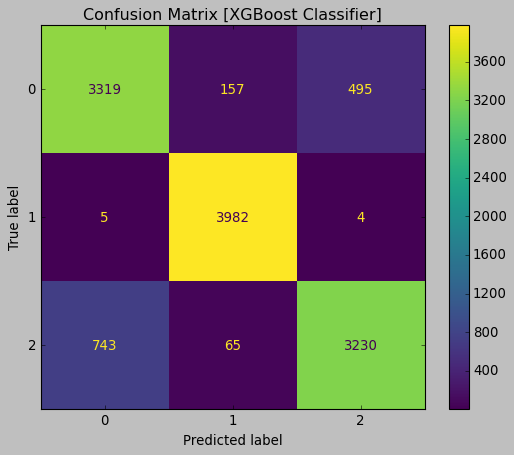

In [52]:
# Also plot the metric
plot_metric(xg_classifier, validX, validY, "XGBoost Classifier")

********************************
### Comparing the models based on the accuracy scores
We have deployed six machine learning algorithms and every algorithm is deployed successfully without any hesitation. We have checked the accuracy of the models based on the accuracy score of each of the models. Now let's take a look at the scores of each models.

|Name of the Model|Accuracy Score|
|:---:|:---:|
|Logistic Regression|87.79%|
|Decision Tree Classifier|79.72%|
|Random Forest Classifier|82.96%|
|Naive Bayes Algorithm|77.94%|
|KNN Algorithm|56.51%|
|XgBoost Classifier|87.86%|

*************************************
### Conclusion
**Comparing all those scores scored by the machine learning algorithms, it is clear that Logistic Regression and XgBoost Classifier are having the upper hand in case of this dataset and after this, we can use Decision Tree Classifier, which is also having good score as compared to the other deployed algorithms**

Best Fitted Models ranking - 
1. Logistic Regression
2. XgBoosting Classifier
3. Random Forest Classifier
4. Decision Tree Calsssifier
5. Multinomial Naive Bayes Classifier
6. KNN Classifier

Hooray!! The models are deployed successfully!


### Hope this project will help you! Thank you!